# AstraDB ColBERT or Pinecone/Weaviate Hybrid Search?
Author: Tiernan Lindauer, Datastax Inc.

## Step 1: Setup

Install the required packages (`requirements.txt`)

In [114]:
# Some minor setup for the notebook
import warnings
import nest_asyncio

# Ignore all warnings
warnings.filterwarnings("ignore")

# Allows for running async code in Jupyter notebooks
nest_asyncio.apply()

In [9]:
import os
import time
import openai
import weaviate
from dotenv import load_dotenv
from langchain_community.retrievers import (
    WeaviateHybridSearchRetriever,
)
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

Load the corpus.

In [25]:
corpus_path = "dataset/movie_scripts/test"

In [24]:
def load_and_split_text(folder_path):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    texts = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            text = file.read()
            texts.extend(text_splitter.split_text(text))
    return texts


corpus = load_and_split_text(corpus_path)

Alternatively, load a dataset from the Hugging Face Datasets library.

In [217]:
from datasets import load_dataset

datasets = {}
def configure_dataset(name: str, lang:str=None):
    if lang:
        datasets[name] = load_dataset(name, lang)
    else:
        datasets[name] = load_dataset(name)

In [218]:
configure_dataset("mteb/amazon_polarity")
configure_dataset("mteb/amazon_counterfactual", "en")
configure_dataset("mteb/quora-retrieval")
configure_dataset("mteb/askubuntudupquestions-reranking")
configure_dataset("mteb/stackexchange-clustering")
configure_dataset("mteb/reddit-clustering-p2p")
configure_dataset("mteb/emotion")
configure_dataset("mteb/arxiv-clustering-p2p")
configure_dataset("mteb/cqadupstack-english", "corpus")
print(list(datasets.keys()))

['mteb/amazon_polarity', 'mteb/amazon_counterfactual', 'mteb/quora-retrieval', 'mteb/askubuntudupquestions-reranking', 'mteb/stackexchange-clustering', 'mteb/reddit-clustering-p2p', 'mteb/emotion', 'mteb/arxiv-clustering-p2p', 'mteb/cqadupstack-english']


In [219]:
corpus = (
    datasets["mteb/amazon_polarity"]['train']['text'] +
    datasets["mteb/amazon_polarity"]['test']['text'] +
    datasets["mteb/amazon_counterfactual"]['train']['text'] +
    datasets["mteb/amazon_counterfactual"]['test']['text'] +
    datasets["mteb/amazon_counterfactual"]['validation']['text'] +
    datasets["mteb/askubuntudupquestions-reranking"]['test']['positive'] +
    datasets["mteb/askubuntudupquestions-reranking"]['test']['negative'] +
    datasets["mteb/reddit-clustering-p2p"]['test']['sentences'] +
    datasets["mteb/emotion"]['train']['text'] +
    datasets["mteb/emotion"]['test']['text'] +
    datasets["mteb/emotion"]['validation']['text'] +
    datasets["mteb/arxiv-clustering-p2p"]['test']['sentences'] +
    datasets["mteb/cqadupstack-english"]['corpus']['text']
)

In [220]:
# Specify the number of results for each search.
n_results = 10

Create Weaviate cluster (no authentication) -- **you need to create this, then come back**!

In [38]:
WEAVIATE_URL = input("Enter your weaviate cluster URL: ")

In [11]:
OPENAI_API_KEY = input("Enter your OpenAI API key: ")

In [39]:
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY
client = weaviate.Client(
    url=WEAVIATE_URL,
    additional_headers={
        "X-Openai-Api-Key": OPENAI_API_KEY,
    },
)
embeddings = OpenAIEmbeddings()

/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/weaviate/warnings.py:162: DeprecationWarning: Dep016: Python client v3 `weaviate.Client(...)` connections and methods are deprecated. Update
            your code to use Python client v4 `weaviate.WeaviateClient` connections and methods.

            For Python Client v4 usage, see: https://weaviate.io/developers/weaviate/client-libraries/python
            For code migration, see: https://weaviate.io/developers/weaviate/client-libraries/python/v3_v4_migration
            
  warnings.warn(


In [155]:
weaviate_retriever = WeaviateHybridSearchRetriever(
    client=client,
    index_name="LangChain",
    text_key="text",
    attributes=['index'],
    create_schema_if_missing=True,
    k=n_results,
)

In [ ]:
# ONLY RUN ONCE!
docs = []
index_val = 0
for doc in corpus:
    docs.append(Document(
        metadata={
            "name": "montypython",
            "date": time.strftime("%m/%d/%Y"),
            "index": index_val,
        },
        page_content=doc
    ))
    index_val += 1
weaviate_retriever.add_documents(docs)
# Now let's load Pinecone

In [17]:
import certifi
from pinecone_text.sparse import BM25Encoder

os.environ['SSL_CERT_FILE'] = certifi.where()

bm25_encoder = BM25Encoder().default()

In [18]:
bm25_encoder.fit(corpus)
current_directory = os.getcwd()
json_file_path = os.path.join(current_directory, "bm25_values.json")

  0%|          | 0/237 [00:00<?, ?it/s]

In [20]:
from pinecone import Pinecone, ServerlessSpec

index_name = "pinecone-hybrid-search-1"

pc_api_key = input("Enter your Pinecone API key: ")
# initialize Pinecone client
pc = Pinecone(api_key=pc_api_key)

# create the index
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=1536,  # dimensionality of dense model
        metric="dotproduct",  # sparse values supported only for dotproduct
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

    metadatas = []
    for i in range(len(corpus)):
        metadatas.append({
            "name": "montypython",
            "date": time.strftime("%m/%d/%Y"),
            "index": i,
        })


In [22]:
index = pc.Index(index_name)

In [156]:
from langchain_community.retrievers import PineconeHybridSearchRetriever

pinecone_retriever = PineconeHybridSearchRetriever(
    embeddings=embeddings, sparse_encoder=bm25_encoder, index=index, top_k=n_results
)

In [27]:
pinecone_retriever.add_texts(corpus, metadatas=metadatas)

  0%|          | 0/8 [00:00<?, ?it/s]

Pure BM25 implementation setup:

In [176]:
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import CountVectorizer

In [180]:
# Tokenize the corpus
tokenized_corpus = [doc.split(" ") for doc in corpus]

# Initialize the BM25 model
bm25 = BM25Okapi(tokenized_corpus)

In [186]:
def bm25_query(text: str, k: int = 5):
    """
    Perform a BM25 query and return the top k document texts and their indices.
    
    Parameters:
        text (str): The query text.
        k (int): The number of top documents to return.
    
    Returns:
        List[Tuple[int, str]]: A list of tuples where each tuple contains the index and text of a top document.
    """
    tokenized_query = text.split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    top_k_indices = doc_scores.argsort()[-k:][::-1]
    top_k_docs = [(index, corpus[index]) for index in top_k_indices]
    return top_k_docs

Let's run an example query to compare the results of Weaviate/Pinecone to the perfect K-Nearest-Neighbors (KNN) search later.

In [28]:
question = "Who is the director of \"Monty Python and the Holy Grail\"?"

In [198]:
print("Weaviate results:")
weaviate_results = weaviate_retriever.invoke(question, score=True)
weaviate_indices = [result.metadata['index'] for result in weaviate_results]
print("    Metadata: ", weaviate_indices)
print("Pinecone results:")
pinecone_results = pinecone_retriever.invoke(question, score=True)
pinecone_indices = [int(result.metadata['index']) for result in pinecone_results]
print("    Metadata: ", pinecone_indices)
print("BM25 results:")
bm25_results = bm25_query(question, k=n_results)
bm25_indices = [index for index, _ in bm25_results]
print("    Indices: ", bm25_indices)

Weaviate results:
    Metadata:  [2, 16, 0, 1, 15, 3, 185, 12, 108, 66]
Pinecone results:
    Metadata:  [0, 1, 2, 15, 16, 3, 202, 65, 231, 108]
BM25 results:
    Indices:  [236, 73, 85, 84, 83, 82, 81, 80, 79, 78]


## Step 2: Process the Perfect K-Nearest-Neighbors (KNN) Search 

In [199]:
from sklearn.neighbors import NearestNeighbors

In [200]:
def embed_texts(texts):
    return embeddings.embed_documents(texts)


corpus_embeddings = embed_texts(corpus)

# Use KNN to find the closest 5 documents
knn = NearestNeighbors(n_neighbors=n_results, metric='cosine').fit(corpus_embeddings)

In [201]:
distances, knn_indices = knn.kneighbors([embeddings.embed_query(question)])
knn_indices = knn_indices[0]
print("KNN results:")
print("    Indices: ", knn_indices)

KNN results:
    Indices:  [  2   0  16   1  15  66 232  64 231 108]


In [202]:
import numpy as np
from scipy.stats import kendalltau


def dcg(relevances, k):
    relevances = np.array(relevances)[:k]
    if relevances.size:
        return np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    return 0.0


def ndcg(relevances, k):
    ideal_relevances = sorted(relevances, reverse=True)
    return dcg(relevances, k) / dcg(ideal_relevances, k) if dcg(ideal_relevances, k) > 0 else 0.0


def get_result_stats(retrieved_docs, ground_truth, k):
    precisions = []
    recalls = []
    f1_scores = []

    for retrieved, relevant in zip(retrieved_docs, ground_truth):
        # Ensure relevant is a list
        relevant = set(relevant)

        # Calculate true positives
        retrieved_set = set(retrieved[:k])
        true_positives = len(retrieved_set & relevant)

        # Calculate Precision
        precision = true_positives / len(retrieved_set) if len(retrieved_set) > 0 else 0
        precisions.append(precision)

        # Calculate Recall
        recall = true_positives / len(relevant) if len(relevant) > 0 else 0
        recalls.append(recall)

        # Calculate F1 Score
        if precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0
        f1_scores.append(f1_score)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)

    mrr = []
    ndcg_scores = []

    for retrieved, relevant in zip(retrieved_docs, ground_truth):
        # Create relevance scores
        relevances = [1 if doc in relevant else 0 for doc in retrieved]

        # Calculate MRR
        reciprocal_rank = 0
        for i, rel in enumerate(relevances):
            if rel == 1:
                reciprocal_rank = 1 / (i + 1)
                break
        mrr.append(reciprocal_rank)

        # Calculate nDCG
        ndcg_score = ndcg(relevances, k)
        ndcg_scores.append(ndcg_score)

    avg_mrr = np.mean(mrr)
    avg_ndcg = np.mean(ndcg_scores)

    return {
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1-Score': avg_f1,
        'MRR': avg_mrr,
        'nDCG': avg_ndcg,
    }

Evaluate the results of the example query above.

In [203]:
print("Weaviate results:", get_result_stats([weaviate_indices], [knn_indices], n_results))
print("Pinecone results: ", get_result_stats([pinecone_indices], [knn_indices], n_results))
print("BM25 results: ", get_result_stats([bm25_indices], [knn_indices], n_results))

Weaviate results: {'Precision': 0.7, 'Recall': 0.7, 'F1-Score': 0.7, 'MRR': 1.0, 'nDCG': 0.972664731083356}
Pinecone results:  {'Precision': 0.7, 'Recall': 0.7, 'F1-Score': 0.7, 'MRR': 1.0, 'nDCG': 0.972664731083356}
BM25 results:  {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'MRR': 0.0, 'nDCG': 0.0}


## Step 3: Setup ColBERT through AstraDB

In [169]:
import time
from langchain.text_splitter import RecursiveCharacterTextSplitter
from ragstack_colbert import CassandraDatabase, ColbertEmbeddingModel, ColbertVectorStore, ColbertRetriever

In [102]:
astra_database_id = input("Enter your AstraDB database ID: ")

In [103]:
astra_token = input("Enter your AstraDB token: ")

In [167]:
keyspace = "benchmarking"
database = CassandraDatabase.from_astra(astra_token=astra_token, database_id=astra_database_id, keyspace=keyspace)
embedding_model = ColbertEmbeddingModel()
vector_store = ColbertVectorStore(database=database, embedding_model=embedding_model)

In [170]:
def store_in_astra(chunks):
    metadatas = []
    for i in range(len(chunks)):
        metadatas.append({"name": "montypython", "date": time.strftime("%m/%d/%Y"), 'index': i})
    vector_store.add_texts(texts=chunks, metadatas=metadatas, doc_id="benchmarking")


store_in_astra(corpus)

In [171]:
colbert_retriever = ColbertRetriever(embedding_model=embedding_model, database=database)

In [172]:
def get_astra_results(query, k=5):
    results = colbert_retriever.text_search(query, k=k)
    return results

In [173]:
print("ColBERT results:")
print(get_astra_results(question, k=n_results))

ColBERT results:

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Who is the director of "Monty Python and the Holy Grail"?, 		 True, 		 None
#> Output IDs: torch.Size([18]), tensor([  101,     1,  2040,  2003,  1996,  2472,  1997,  1000, 18446, 18750,
         1998,  1996,  4151, 24665, 12502,  1000,  1029,   102])
#> Output Mask: torch.Size([18]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

[(Chunk(doc_id='benchmarking', chunk_id=15, text='EARL J. LLAMA\n\n                           MIKE Q. LLAMA III\n\n                                SY LLAMA\n\n                            MERLE Z. LLAMA IX\n\nTITLE OUT:\n\n TITLE IN:\n\n                              Directed by\n\n                          40 SPECIALLY TRAINED\n\n                        ECUADORIAN MOUNTAIN LLAMAS\n\n                         6 VENEZUELAN RED LLAMAS\n\n                       142 MEXICAN WHOOPING LLAMAS\n\n                        14 NORTH CHILEAN GUANACOS\n\n  

In [174]:
from tqdm import tqdm
from time import time

In [215]:
all_knn_indices = []
all_weaviate_indices = []
all_pinecone_indices = []
all_colbert_indices = []
all_bm25_indices = []

weaviate_latencies = []
pinecone_latencies = []
colbert_latencies = []
bm25_latencies = []

with open('dataset/queries/holy_grail_result.txt', 'r') as f:
    for line in tqdm(f.readlines()):
        line = line.strip()

        start = time()
        weaviate_results = weaviate_retriever.invoke(line)
        end = time()
        weaviate_latencies.append(end - start)
        weaviate_indices = [result.metadata['index'] for result in weaviate_results]
        all_weaviate_indices.append(weaviate_indices)

        start = time()
        pinecone_results = pinecone_retriever.invoke(line)
        end = time()
        pinecone_latencies.append(end - start)
        pinecone_indices = [int(result.metadata['index']) for result in pinecone_results]
        all_pinecone_indices.append(pinecone_indices)

        start = time()
        colbert_results = get_astra_results(line)
        end = time()
        colbert_indices = [int(float(result[0].metadata['index'])) for result in colbert_results]
        colbert_latencies.append(end - start)
        all_colbert_indices.append(colbert_indices)
        
        start = time()
        bm25_results = bm25_query(line, k=n_results)
        end = time()
        bm25_indices = [index for index, _ in bm25_results]
        bm25_latencies.append(end - start)
        all_bm25_indices.append(bm25_indices)

        distances, knn_indices = knn.kneighbors([embeddings.embed_query(line)])
        knn_indices = knn_indices[0]
        all_knn_indices.append(knn_indices)

100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


In [216]:
weaviate_stats = get_result_stats(all_weaviate_indices, all_knn_indices, n_results)
pinecone_stats = get_result_stats(all_pinecone_indices, all_knn_indices, n_results)
colbert_stats = get_result_stats(all_colbert_indices, all_knn_indices, n_results)
bm25_stats = get_result_stats(all_bm25_indices, all_knn_indices, n_results)

In [211]:
from rich.text import Text
import rich
from rich.console import Console

console = Console()

# Print a table of the results (Weaviate, Pinecone, ColBERT vs the different stats)
table = rich.table.Table(title="Retrieval Results @k={}".format(n_results), show_edge=False)
table.add_column("Metric", style="cyan")
table.add_column("Weaviate", style="magenta")
table.add_column("Pinecone", style="green")
table.add_column("AstraDB + ColBERT", style="blue")
table.add_column("BM25", style="yellow")


def format_cell(value, is_max=True):
    text = Text(str(value))
    if is_max:
        text.stylize("bold underline")
    return text


# Add stats to table with formatting
for metric in weaviate_stats:
    values = [
        weaviate_stats[metric],
        pinecone_stats[metric],
        colbert_stats[metric],
        bm25_stats[metric],
    ]
    max_value = max(values)
    formatted_values = [
        format_cell(value, is_max=(value == max_value)) for value in values
    ]
    table.add_row(metric, *formatted_values)

# Calculate average latencies and add them to the table
avg_weaviate_latency = sum(weaviate_latencies) / len(weaviate_latencies)
avg_pinecone_latency = sum(pinecone_latencies) / len(pinecone_latencies)
avg_colbert_latency = sum(colbert_latencies) / len(colbert_latencies)
avg_bm25_latency = sum(bm25_latencies) / len(bm25_latencies)

latencies = [avg_weaviate_latency, avg_pinecone_latency, avg_colbert_latency, avg_bm25_latency]
min_latency = min(latencies)
formatted_latencies = [
    format_cell(latency, is_max=(latency == min_latency)) for latency in latencies
]

table.add_row("Average Latency", *formatted_latencies)

# Print the table
console.print(table)

                                          Retrieval Results @k=10                                          
 Metric          ┃ Weaviate           ┃ Pinecone            ┃ AstraDB + ColBERT   ┃ BM25                   
━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━
 Precision       │ 0.505              │ 0.8460000000000001  │ 0.1                 │ nan                    
 Recall          │ 0.505              │ 0.8460000000000001  │ 0.05                │ nan                    
 F1-Score        │ 0.505              │ 0.8460000000000001  │ 0.06666666666666667 │ nan                    
 MRR             │ 0.865              │ 0.8595952380952382  │ 0.218               │ nan                    
 nDCG            │ 0.8962652356607559 │ 0.9159726190401632  │ 0.2614707987173333  │ nan                    
 Average Latency │ 0.5097701787948609 │ 0.27424402475357057 │ 1.0930203342437743  │ 0.00027930498123168946 

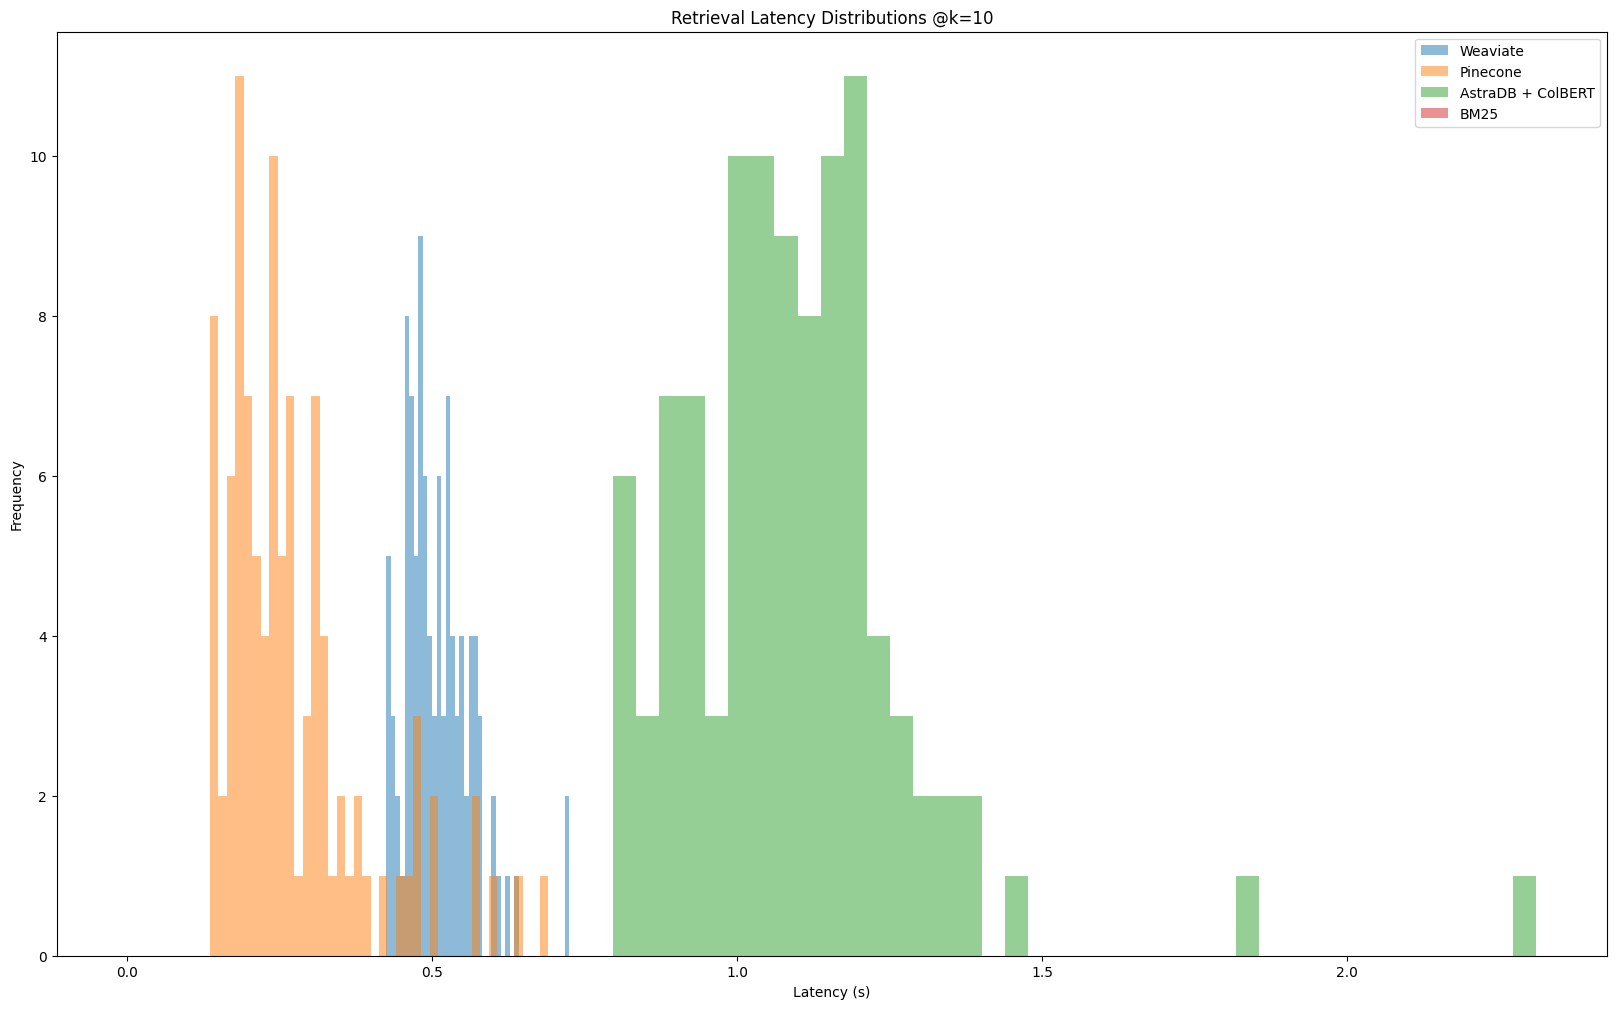

In [207]:
# Plot latency distributions
import matplotlib.pyplot as plt

bins = 40
plt.hist(weaviate_latencies, bins=bins, alpha=0.5, label='Weaviate')
plt.hist(pinecone_latencies, bins=bins, alpha=0.5, label='Pinecone')
plt.hist(colbert_latencies, bins=bins, alpha=0.5, label='AstraDB + ColBERT')
plt.hist(bm25_latencies, bins=bins, alpha=0.5, label='BM25')

plt.legend(loc='upper right')
plt.xlabel('Latency (s)')
plt.ylabel('Frequency')
plt.title('Retrieval Latency Distributions @k={}'.format(n_results))

# set the size bigger
plt.rcParams["figure.figsize"] = (20, 12)